# Aircraft Safety Risk Analysis

![TakeOff](./Images/take_off.jpg)

## Overview

This project analyzes the Data Source National Transportation Safety Board (NTSB) aviation accident/incident database, assessing risk of injury for a variety of airplane models based on historical accident data.

 - Assesses risk based on fatal and non-fatal injury rates of aircraft models

 - Recommendation of three safest aircraft models, based on historical injury rates, for each of three passenger capacity classes (small, medium, large)



## Business Problem

 - The company is interested in purchasing and operating airplanes for commercial and private enterprises and needs recommendation from a safety perspective.

 - This assessment will make and aircraft model recommendations based on historical injury outcomes; prioritizing minimizing fatal then non-fatal injury rates.

## Data Understanding
Within the NTSB aviation accident/incident database, each record is an aviation accident/incident from circa 1970 through 2022. Each column represents a catagorical or numeric attribute of the event record as shown below.

## 1.  Importing and loading data sets, initial inspection
## =========================================================================

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

df = pd.read_csv('Data\AviationData.csv', encoding='latin-1', low_memory=False)
states_df = pd.read_csv('Data\\USState_Codes.csv')

In [98]:
# code the state names and abbreviations into the main df, for potential geographic analysis
states_dict = {}
for index, row in states_df.iterrows():
    states_dict[row[1]] = row[0]
    
    
def state_lookup(abbrev):
    if abbrev in states_dict.keys():
        return states_dict[abbrev]
    else:
        return None

df['State.Name'] = df['Location']
df['State.Abbrev'] = df['Location'].map(lambda x: str(x)[-2:])
df['State.Name'] = df['State.Abbrev'].map(lambda x: state_lookup(x) if state_lookup(x) != None else x)
df['State.Name'] = df['State.Name'].map(lambda x: x if x in states_dict.values() else 'NA')


In [99]:
# Check that the state names are clean
df['State.Name'].value_counts().tail(25)

South Carolina    974
Iowa              910
Maryland          815
Mississippi       813
Wyoming           739
Nebraska          727
Kentucky          650
North Dakota      596
Maine             507
Connecticut       502
Hawaii            499
South Dakota      446
West Virginia     394
New Hampshire     368
Vermont           241
Rhode Island      158
American Samoa    131
Delaware          118
Puerto Rico       114
Gulf of mexico     44
Washington_DC      42
Atlantic ocean     26
Pacific ocean      17
Guam                8
Virgin Islands      6
Name: State.Name, dtype: int64

In [100]:
# take a look at the value counts for general understanding
for column in df.columns:
    print(f'Column Name: {column}')
    print(f'{df[column].value_counts()} \n')

Column Name: Event.Id
20001214X45071    3
20001212X19172    3
20070610X00702    2
20001212X16913    2
20040331X00402    2
                 ..
20001211X16225    1
20001214X38286    1
20001213X33964    1
20021023X05369    1
20001214X44881    1
Name: Event.Id, Length: 87951, dtype: int64 

Column Name: Investigation.Type
Accident    85015
Incident     3874
Name: Investigation.Type, dtype: int64 

Column Name: Accident.Number
WPR22LA143    2
CEN22FA424    2
ERA22FA338    2
CEN22LA346    2
DCA22WA130    2
             ..
CEN12CA226    1
NYC03FA186    1
GAA18CA349    1
MIA96FA067    1
MIA04CA053    1
Name: Accident.Number, Length: 88863, dtype: int64 

Column Name: Event.Date
1984-06-30    25
1982-05-16    25
2000-07-08    25
1984-08-25    24
1986-05-17    24
              ..
2012-11-09     1
2020-04-17     1
2018-12-28     1
1996-02-25     1
2005-11-14     1
Name: Event.Date, Length: 14782, dtype: int64 

Column Name: Location
ANCHORAGE, AK        434
MIAMI, FL            200
ALBUQUERQUE, N

## 2. Data Cleaning
## =========================================================================

In [101]:
#Dropping these columns due to Not enough data and/or not enough relevance to the analysis
drop_columns = ['Latitude',          
                'Longitude',         
                'Schedule',          
                'Air.carrier',       
                'Airport.Code',      
                'FAR.Description',   
                'Publication.Date',  
                'Report.Status',
                'Accident.Number',
                'Registration.Number'
               ]
df = df.drop(columns=drop_columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Event.Date              88889 non-null  object 
 3   Location                88837 non-null  object 
 4   Country                 88663 non-null  object 
 5   Airport.Name            52790 non-null  object 
 6   Injury.Severity         87889 non-null  object 
 7   Aircraft.damage         85695 non-null  object 
 8   Aircraft.Category       32287 non-null  object 
 9   Make                    88826 non-null  object 
 10  Model                   88797 non-null  object 
 11  Amateur.Built           88787 non-null  object 
 12  Number.of.Engines       82805 non-null  float64
 13  Engine.Type             81812 non-null  object 
 14  Purpose.of.flight       82697 non-null

In [102]:
#Take a look at amateur built values
df['Amateur.Built'].value_counts()


No     80312
Yes     8475
Name: Amateur.Built, dtype: int64

In [103]:
#Take a look at amateur built NaN
df['Amateur.Built'].isna().sum()

102

In [104]:
# Stakeholders will not want to purchase airplanes built by amateurs for liability reasons
# dropping 'Amateur.Built' == 'Yes' or NaN 
df = df[(df['Amateur.Built'] == 'No') & (df['Amateur.Built'].notna())]

In [105]:
# looking at 'Investigation.Type'
df['Investigation.Type'].value_counts()

Accident    76520
Incident     3792
Name: Investigation.Type, dtype: int64

In [106]:
# see what the difference is in 'Investigation.Type'
df.groupby('Investigation.Type')[['Total.Fatal.Injuries', 'Total.Uninjured']].describe()

Total.Fatal.Injuries                                     \
                                  count      mean       std  min  25%  50%   
Investigation.Type                                                           
Accident                        66952.0  0.695782  5.851423  0.0  0.0  0.0   
Incident                         3203.0  0.006556  0.094941  0.0  0.0  0.0   

                               Total.Uninjured                             \
                    75%    max           count       mean        std  min   
Investigation.Type                                                          
Accident            0.0  349.0         71746.0   3.467538  20.626871  0.0   
Incident            0.0    3.0          3679.0  50.334874  83.425972  0.0   

                                           
                    25%  50%   75%    max  
Investigation.Type                         
Accident            0.0  1.0   2.0  699.0  
Incident            1.0  4.0  78.0  588.0

In [107]:
# seems like Incident tends to be much less serious, dont want to confound the data
# dropping Incident from Investigation.Type
df = df[df['Investigation.Type'] == 'Accident']

In [108]:
# Take a closer look at country
df['Country'].value_counts()


United States           71596
Brazil                    325
Canada                    301
Mexico                    281
United Kingdom            209
                        ...  
United Arab Emirates        1
Qatar                       1
Singapore                   1
Ivory Coast                 1
Guam                        1
Name: Country, Length: 207, dtype: int64

In [109]:
# Vast majority of this data set is from US crashes
# we shouldn't assume the data fits outside of US, removing non-US
df = df[df['Country'] == 'United States']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71596 entries, 0 to 88888
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                71596 non-null  object 
 1   Investigation.Type      71596 non-null  object 
 2   Event.Date              71596 non-null  object 
 3   Location                71586 non-null  object 
 4   Country                 71596 non-null  object 
 5   Airport.Name            44652 non-null  object 
 6   Injury.Severity         71544 non-null  object 
 7   Aircraft.damage         70483 non-null  object 
 8   Aircraft.Category       24081 non-null  object 
 9   Make                    71596 non-null  object 
 10  Model                   71590 non-null  object 
 11  Amateur.Built           71596 non-null  object 
 12  Number.of.Engines       70039 non-null  float64
 13  Engine.Type             68968 non-null  object 
 14  Purpose.of.flight       69716 non-null

In [110]:
#Take a look at Injury.Severity
df.groupby('Injury.Severity')['Total.Fatal.Injuries'].mean().head(10)

Injury.Severity
Fatal           1.784388
Fatal(1)        1.000000
Fatal(10)      10.000000
Fatal(11)      11.000000
Fatal(110)    110.000000
Fatal(111)    111.000000
Fatal(12)      12.000000
Fatal(13)      13.000000
Fatal(132)    132.000000
Fatal(135)    135.000000
Name: Total.Fatal.Injuries, dtype: float64

In [111]:
# looks like in 'Injury.Severity', when Fatal(x), x is just = Total.Fatal.Injuries
# so recoding all Fatal(x) to just Fatal
df['Injury.Severity'] = df['Injury.Severity'].map(lambda x: 'Fatal' if str(x)[:5] == 'Fatal' else x)
df['Injury.Severity'].value_counts()

Non-Fatal      58454
Fatal          12762
Minor            181
Serious          133
Unavailable       14
Name: Injury.Severity, dtype: int64

In [112]:
# A lot of missing data in these catagorical columns but may be relevant data,
# so recoding the NaN as 'DATA MISSING' for now
missing_data_dict = {'Airport.Name': 'DATA MISSING',
                     'Aircraft.Category': 'DATA MISSING',
                     'Broad.phase.of.flight': 'DATA MISSING',
                     'Purpose.of.flight': 'DATA MISSING'}
df = df.fillna(missing_data_dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71596 entries, 0 to 88888
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                71596 non-null  object 
 1   Investigation.Type      71596 non-null  object 
 2   Event.Date              71596 non-null  object 
 3   Location                71586 non-null  object 
 4   Country                 71596 non-null  object 
 5   Airport.Name            71596 non-null  object 
 6   Injury.Severity         71544 non-null  object 
 7   Aircraft.damage         70483 non-null  object 
 8   Aircraft.Category       71596 non-null  object 
 9   Make                    71596 non-null  object 
 10  Model                   71590 non-null  object 
 11  Amateur.Built           71596 non-null  object 
 12  Number.of.Engines       70039 non-null  float64
 13  Engine.Type             68968 non-null  object 
 14  Purpose.of.flight       71596 non-null

In [113]:
# Take a closer look at 'Aircraft.Catagory' due to relevance
df['Aircraft.Category'].value_counts()


DATA MISSING         47515
Airplane             20564
Helicopter            2538
Glider                 472
Balloon                225
Weight-Shift           139
Powered Parachute       82
Gyrocraft               31
Ultralight              13
WSFT                     9
Blimp                    4
Powered-Lift             2
Rocket                   1
Unknown                  1
Name: Aircraft.Category, dtype: int64

In [114]:
# Stakeholders are interested in airplane potential, and not helicopters etc.
df = df[(df['Aircraft.Category'] == 'Airplane') | 
        (df['Aircraft.Category'] == 'DATA MISSING')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68079 entries, 0 to 88888
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                68079 non-null  object 
 1   Investigation.Type      68079 non-null  object 
 2   Event.Date              68079 non-null  object 
 3   Location                68069 non-null  object 
 4   Country                 68079 non-null  object 
 5   Airport.Name            68079 non-null  object 
 6   Injury.Severity         68029 non-null  object 
 7   Aircraft.damage         67079 non-null  object 
 8   Aircraft.Category       68079 non-null  object 
 9   Make                    68079 non-null  object 
 10  Model                   68073 non-null  object 
 11  Amateur.Built           68079 non-null  object 
 12  Number.of.Engines       66737 non-null  float64
 13  Engine.Type             66216 non-null  object 
 14  Purpose.of.flight       68079 non-null

In [115]:
# looking at the stats for the continuous data, for possible imputing
df.describe()

,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,66737.000000,59444.000000,58814.000000,59348.000000,64144.000000
mean,1.132595,0.441811,0.254276,0.340517,3.056778
std,0.392511,2.650981,1.165291,1.363522,18.154499
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000
max,8.000000,265.000000,137.000000,125.000000,699.000000


In [116]:
#imputing the median for the injuries columns, to preserve the data
missing_data_dict = {'Total.Fatal.Injuries': 0,
                     'Total.Serious.Injuries': 0,
                     'Total.Minor.Injuries': 0,
                     'Total.Uninjured': 1}
df = df.fillna(missing_data_dict)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68079 entries, 0 to 88888
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                68079 non-null  object 
 1   Investigation.Type      68079 non-null  object 
 2   Event.Date              68079 non-null  object 
 3   Location                68069 non-null  object 
 4   Country                 68079 non-null  object 
 5   Airport.Name            68079 non-null  object 
 6   Injury.Severity         68029 non-null  object 
 7   Aircraft.damage         67079 non-null  object 
 8   Aircraft.Category       68079 non-null  object 
 9   Make                    68079 non-null  object 
 10  Model                   68073 non-null  object 
 11  Amateur.Built           68079 non-null  object 
 12  Number.of.Engines       66737 non-null  float64
 13  Engine.Type             66216 non-null  object 
 14  Purpose.of.flight       68079 non-null

In [117]:
# check out the data chronologically
df['Event.Date'] = pd.to_datetime(df['Event.Date'])
df['Event.Date'].dt.year.value_counts().tail(10)


2015    939
2021    915
2014    903
2020    853
1979      2
1948      1
1962      1
1974      1
1977      1
1981      1
Name: Event.Date, dtype: int64

In [118]:
#drop the very old one-offs, questionable data
df = df[df['Event.Date'].dt.year > 1981]

In [119]:
# cleaning up 'Make' and 'Model' to standardize catagorical values
df['Make'] = df['Make'].str.upper()
df['Model'] = df['Model'].str.replace(' ', '')

## 3. Feature Engineering
## =========================================================================

In [120]:
# Assumption: the total number of passengers per flight = all numeric injury columns and uninjured column 
# added together. this should give us the number of passengers on each aircraft at the time of the event.  
# This will allow us to normalize severity of each event across aircraft models even though there are widely 
# varying numbers of passengers on each plane due to differnet types of aircraft models
df['Total.Passengers'] = (df['Total.Fatal.Injuries'] + df['Total.Serious.Injuries'] + 
                          df['Total.Minor.Injuries'] + df['Total.Uninjured'])

#Save out the reduced file for tableau visualization
df.to_csv('Data\AviationDataReduced.csv')

In [121]:
# Doing the main aggregation here
# ============================================================

# classify each model into a passenger capacity bin
def classify_capacity(capacity):
    if capacity > 150:
        return 'Large'
    elif capacity > 2:
        return 'Medium'
    else:
        return 'Small'

# grouping by 'Model', 'Make' and aggregating by:
#          Total.Passengers median will give us the typical amount of passengers flying per model
#          Total.Passengers sum will give us the all-time passenger load per model
#          Total.Minor.Injuries sum will give us the all-time minor injuries per model
#          Total.Serious.Injuries sum will give us the all-time serious injuries per model
#          Total.Fatal.Injuries sum will give us the all-time fatalities per model
agg_df = df.groupby(['Model', 'Make']).agg({'Total.Passengers': ['median', 'sum'], 
                                            'Total.Minor.Injuries': ['sum'],
                                            'Total.Serious.Injuries': ['sum'],
                                            'Total.Fatal.Injuries': ['sum']})

# Rename the columns for clarity
agg_df.columns = ['Median.Total.Passengers', 
                  'Sum.Total.Passengers', 
                  'Sum.Total.Minor.Injuries',
                  'Sum.Total.Serious.Injuries', 
                  'Sum.Total.Fatal.Injuries']

# Using the function above to classify each model according to passenger capacity
agg_df['Capacity.Class'] = agg_df['Median.Total.Passengers'].map(lambda x: classify_capacity(x))

# create column of percent fatalities for entire history of the model
# this will be the normalized output by which to compare models
agg_df['Percent.Fatal.Injuries'] = agg_df['Sum.Total.Fatal.Injuries'] / agg_df['Sum.Total.Passengers'] * 100

# Create a column for non-fatal injuries adding serious and minor together
agg_df['Sum.Total.Non-Fatal.Injuries'] = agg_df['Sum.Total.Minor.Injuries'] + agg_df['Sum.Total.Serious.Injuries']

# create column of percent fatalities for entire history of the model
# this will be the normalized output by which to compare models
agg_df['Percent.Non-Fatal.Injuries'] = agg_df['Sum.Total.Non-Fatal.Injuries'] / agg_df['Sum.Total.Passengers'] * 100

# want the make and model to be columns
agg_df = agg_df.reset_index()

# Create a column that contains both make and model for visualization purposes
agg_df['Make.Model'] = agg_df['Make'] + ' ' + agg_df['Model']


# order the columns for readablity
agg_df = agg_df[['Make',
                 'Model', 
                 'Make.Model',
                 'Median.Total.Passengers', 
                 'Capacity.Class', 
                 'Sum.Total.Non-Fatal.Injuries',
                 'Sum.Total.Fatal.Injuries', 
                 'Sum.Total.Passengers', 
                 'Percent.Non-Fatal.Injuries',
                 'Percent.Fatal.Injuries']]


# filter out models that do not have high volume, want to see at least 1000 total passengers for good sample size
agg_df = agg_df[agg_df['Sum.Total.Passengers'] > 1000]

# save it out to csv for Tableau visualization
agg_df.to_csv('Data\AviationDataAggregated.csv')

## 4. Analysis
## =========================================================================

In [122]:
# lets have a look at the aggregated data
agg_df.sort_values(by='Percent.Fatal.Injuries', ascending=False).head()

,Make,Model,Make.Model,Median.Total.Passengers,Capacity.Class,Sum.Total.Non-Fatal.Injuries,Sum.Total.Fatal.Injuries,Sum.Total.Passengers,Percent.Non-Fatal.Injuries,Percent.Fatal.Injuries
5962,PIPER,PA-28-181,PIPER PA-28-181,2.0,Small,294.0,340.0,1293.0,22.737819,26.295437
5955,PIPER,PA-28-180,PIPER PA-28-180,2.0,Small,340.0,260.0,1253.0,27.134876,20.750200
5953,PIPER,PA-28-161,PIPER PA-28-161,2.0,Small,249.0,209.0,1144.0,21.765734,18.269231
280,CESSNA,172N,CESSNA 172N,2.0,Small,532.0,389.0,2313.0,23.000432,16.817985
282,CESSNA,172P,CESSNA 172P,2.0,Small,321.0,220.0,1345.0,23.866171,16.356877


In [123]:
# Looks like we narrowed the field of models down to 36:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 173 to 5962
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Make                          36 non-null     object 
 1   Model                         36 non-null     object 
 2   Make.Model                    36 non-null     object 
 3   Median.Total.Passengers       36 non-null     float64
 4   Capacity.Class                36 non-null     object 
 5   Sum.Total.Non-Fatal.Injuries  36 non-null     float64
 6   Sum.Total.Fatal.Injuries      36 non-null     float64
 7   Sum.Total.Passengers          36 non-null     float64
 8   Percent.Non-Fatal.Injuries    36 non-null     float64
 9   Percent.Fatal.Injuries        36 non-null     float64
dtypes: float64(6), object(4)
memory usage: 3.1+ KB


In [124]:
# Distributions below and the Q1 of Median.Total.Passengers indicates distribution skewed toward
# 2-passenger aircraft, will have to go back and set our capacity classes to even them out
agg_df.describe()

,Median.Total.Passengers,Sum.Total.Non-Fatal.Injuries,Sum.Total.Fatal.Injuries,Sum.Total.Passengers,Percent.Non-Fatal.Injuries,Percent.Fatal.Injuries
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,121.000000,167.388889,89.833333,1588.388889,9.838343,5.454917
std,107.344971,199.254221,124.574820,635.234457,10.519796,7.533538
min,1.000000,2.000000,0.000000,1013.000000,0.186047,0.000000
25%,2.000000,10.750000,0.000000,1162.000000,0.922191,0.000000
50%,126.500000,61.500000,2.500000,1319.000000,4.186551,0.177627
75%,177.375000,277.500000,170.750000,1847.500000,21.052402,10.486280
max,348.000000,654.000000,389.000000,3412.000000,35.466377,26.295437


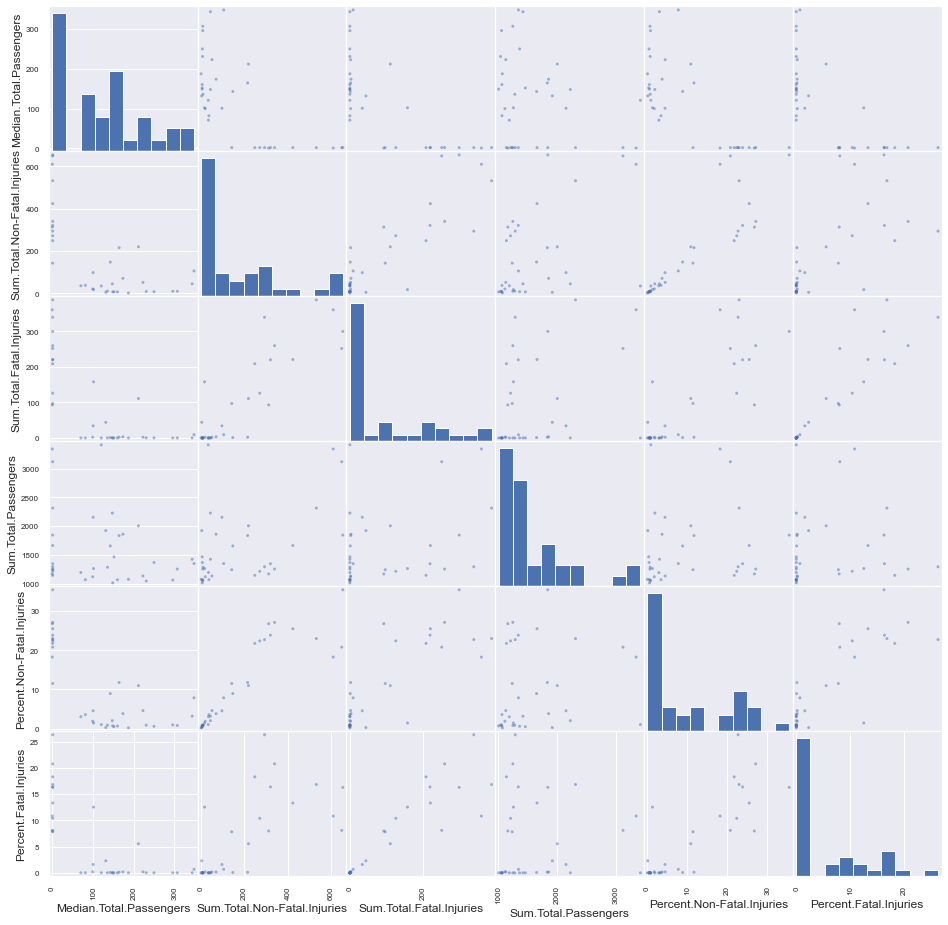

In [125]:
# the only correlations here are expected between the injury data and calculated columns
ax = pd.plotting.scatter_matrix(agg_df, figsize=(16,16))

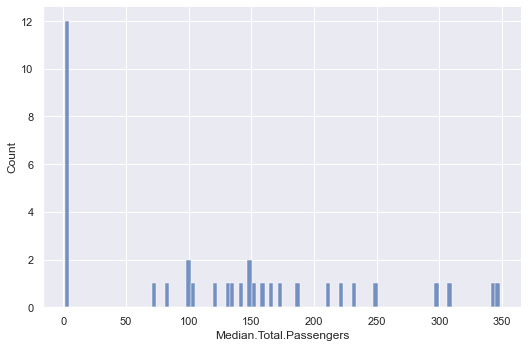

In [126]:
# get better resolution on model capacities to stear classification distribution
# big spike at 2!
graph = sns.displot(data=agg_df['Median.Total.Passengers'], bins=100, height=5, aspect=1.5)

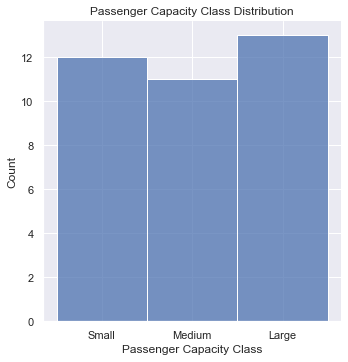

In [127]:
# even classes based on our choices of bins for model capacity
ax = sns.displot(data=agg_df['Capacity.Class'])
plt.title('Passenger Capacity Class Distribution')
plt.xlabel('Passenger Capacity Class')
plt.show()

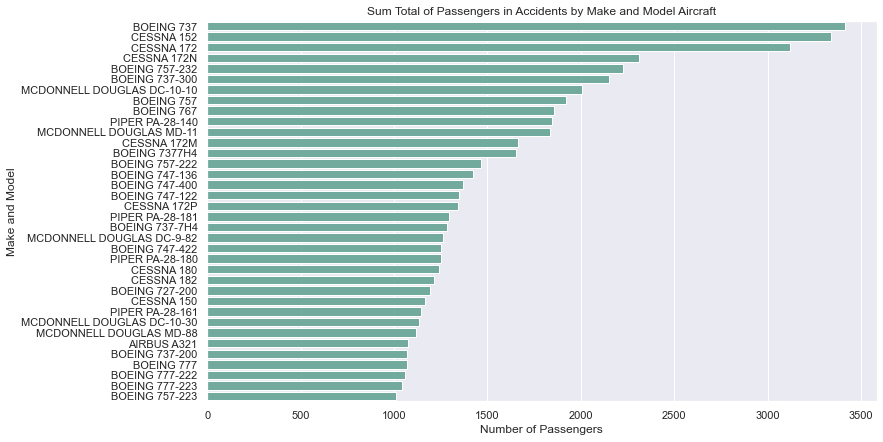

In [128]:
# Now lets see what the total number of passengers were for each model
# Confirming >1000 for each
plt.figure(figsize=(12, 7))
agg_df = agg_df.sort_values(['Sum.Total.Passengers'], ascending=False).reset_index(drop=True)

# plot a bar chart
ax = sns.barplot(
    y='Make.Model', 
    x='Sum.Total.Passengers', 
    data=agg_df,
    estimator=sum, 
    errorbar=None, 
    color='#69b3a2')
ax.set(xlabel='Number of Passengers', ylabel='Make and Model')  # Set the labels
plt.title('Sum Total of Passengers in Accidents by Make and Model Aircraft')  # Optional: Add a title
plt.show()

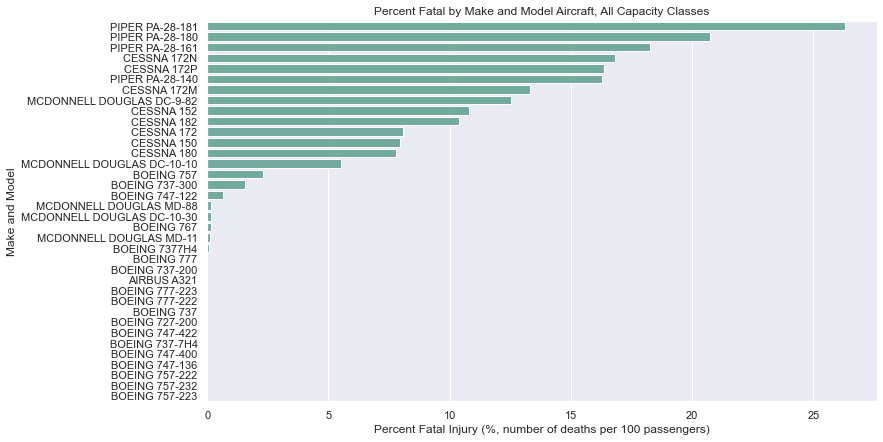

In [129]:
# What is the percent fatal (that is, per 100 passengers how many died)
# for each model?  It is clear that we need to treat the small class differently (i.e. Piper, Cessna)
plt.figure(figsize=(12, 7))
agg_df = agg_df.sort_values(['Percent.Fatal.Injuries'], ascending=False).reset_index(drop=True)

# plot a bar chart
ax = sns.barplot(
    y='Make.Model', 
    x='Percent.Fatal.Injuries', 
    data=agg_df,
    estimator=sum, 
    errorbar=None, 
    color='#69b3a2')
ax.set(xlabel='Percent Fatal Injury (%, number of deaths per 100 passengers)', ylabel='Make and Model')  # Set the labels
plt.title('Percent Fatal by Make and Model Aircraft, All Capacity Classes')  # Optional: Add a title
plt.show()

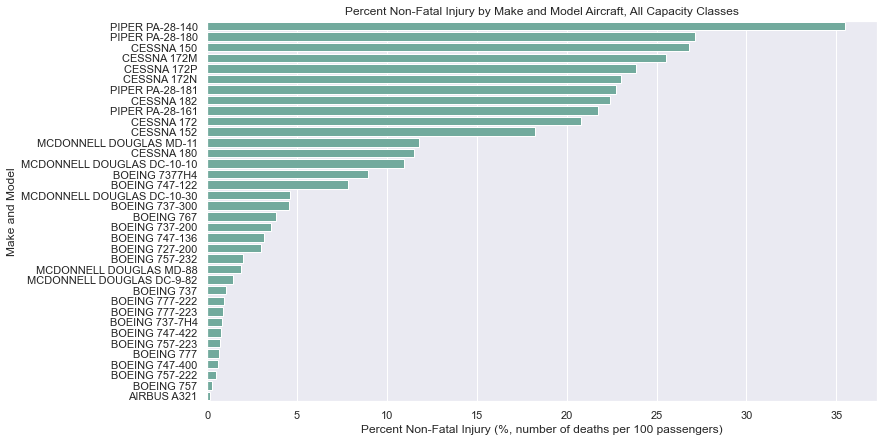

In [130]:
# What is the percent non-fatal injuries (that is, per 100 passengers how many received non-fatal injury)
# for each model.  Small class still dominates but the bars now reach into the larger classes
plt.figure(figsize=(12, 7))
agg_df = agg_df.sort_values(['Percent.Non-Fatal.Injuries'], ascending=False).reset_index(drop=True)

# plot a bar chart
ax = sns.barplot(
    y='Make.Model', 
    x='Percent.Non-Fatal.Injuries', 
    data=agg_df,
    estimator=sum, 
    errorbar=None, 
    color='#69b3a2')
ax.set(xlabel='Percent Non-Fatal Injury (%, number of deaths per 100 passengers)', ylabel='Make and Model')  # Set the labels
plt.title('Percent Non-Fatal Injury by Make and Model Aircraft, All Capacity Classes')  # Optional: Add a title
plt.show()

# Comparison of Capacity Classes




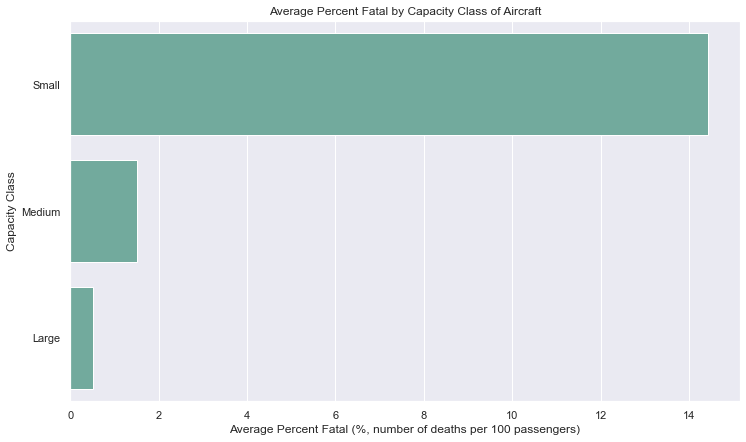

In [131]:
# looks like the smaller planes are more dangerous, lets have a closer look at Fatal
plt.figure(figsize=(12, 7))
agg_df = agg_df.sort_values(['Percent.Fatal.Injuries'], ascending=False).reset_index(drop=True)

# plot a bar chart
ax = sns.barplot(
    y='Capacity.Class', 
    x='Percent.Fatal.Injuries', 
    data=agg_df,
    estimator='mean', 
    errorbar=None, 
    color='#69b3a2')
ax.set(xlabel='Average Percent Fatal (%, number of deaths per 100 passengers)', ylabel='Capacity Class')  # Set the labels
plt.title('Average Percent Fatal by Capacity Class of Aircraft')  # Optional: Add a title
plt.show()

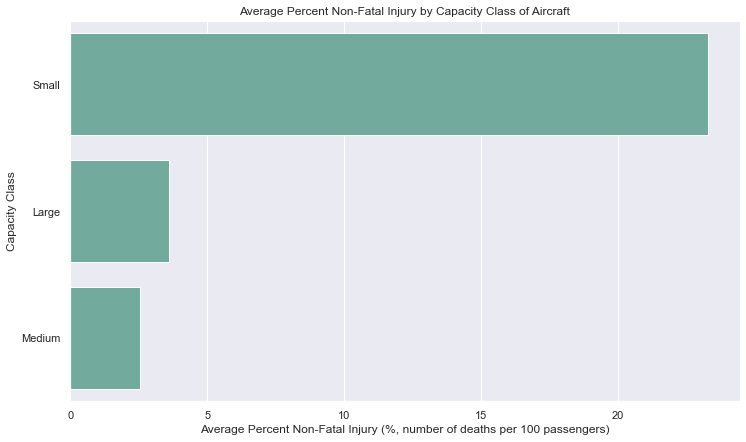

In [132]:
# looks like the smaller planes are more dangerous, lets have a closer look at Non-Fatal
plt.figure(figsize=(12, 7))
agg_df = agg_df.sort_values(['Percent.Non-Fatal.Injuries'], ascending=False).reset_index(drop=True)

# plot a bar chart
ax = sns.barplot(
    y='Capacity.Class', 
    x='Percent.Non-Fatal.Injuries', 
    data=agg_df,
    estimator='mean', 
    errorbar=None, 
    color='#69b3a2')
ax.set(xlabel='Average Percent Non-Fatal Injury (%, number of deaths per 100 passengers)', ylabel='Capacity Class')  # Set the labels
plt.title('Average Percent Non-Fatal Injury by Capacity Class of Aircraft')  # Optional: Add a title
plt.show()

# Class Comparison Result
We will not recommend the company uses Small class aircraft based on poor safety history compared to the other classes

# Small Class (<3 Passenger) Analysis
We will first look at the Percent Fatal Injury data 

In [133]:
# top 5 safest small class based on Percent Fatal
small_df = agg_df[agg_df['Capacity.Class'] == 'Small']
small_df.sort_values(by='Percent.Fatal.Injuries', ascending=True).head(5)

,Make,Model,Make.Model,Median.Total.Passengers,Capacity.Class,Sum.Total.Non-Fatal.Injuries,Sum.Total.Fatal.Injuries,Sum.Total.Passengers,Percent.Non-Fatal.Injuries,Percent.Fatal.Injuries
12,CESSNA,180,CESSNA 180,2.0,Small,143.0,97.0,1242.0,11.513688,7.809984
2,CESSNA,150,CESSNA 150,1.0,Small,313.0,93.0,1168.0,26.797945,7.962329
9,CESSNA,172,CESSNA 172,2.0,Small,649.0,252.0,3118.0,20.814625,8.082104
7,CESSNA,182,CESSNA 182,2.0,Small,272.0,126.0,1214.0,22.405272,10.378913
10,CESSNA,152,CESSNA 152,1.0,Small,610.0,361.0,3340.0,18.263473,10.808383


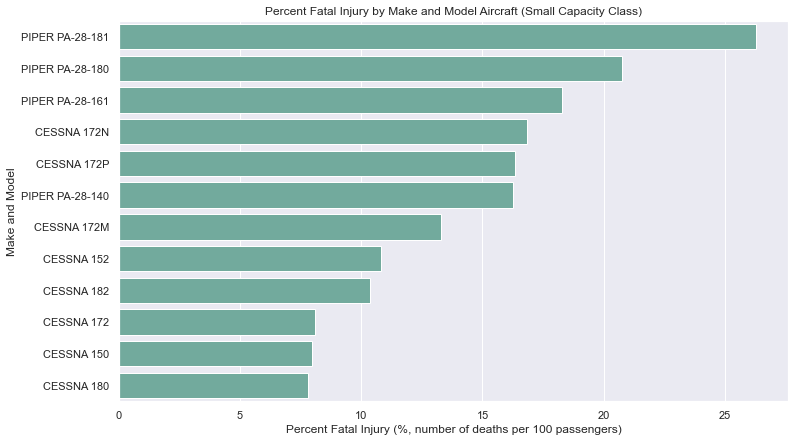

In [134]:
# look at just the small class for percent of fatalities
plt.figure(figsize=(12, 7))
small_df = small_df.sort_values(['Percent.Fatal.Injuries'], ascending=False).reset_index(drop=True)

# plot a bar chart
ax = sns.barplot(
    y='Make.Model', 
    x='Percent.Fatal.Injuries', 
    data=small_df,
    estimator=sum, 
    errorbar=None, 
    color='#69b3a2')
x_min, x_max = ax.get_xlim()
ax.set(xlabel='Percent Fatal Injury (%, number of deaths per 100 passengers)', ylabel='Make and Model')  # Set the labels
plt.title('Percent Fatal Injury by Make and Model Aircraft (Small Capacity Class)')  # Optional: Add a title
plt.show()

Now look at the Non-Fatal Injury data

In [135]:
# top 5 safest small class based on Percent Non-Fatal
small_df = agg_df[agg_df['Capacity.Class'] == 'Small']
small_df.sort_values(by='Percent.Non-Fatal.Injuries', ascending=True).head(5)

,Make,Model,Make.Model,Median.Total.Passengers,Capacity.Class,Sum.Total.Non-Fatal.Injuries,Sum.Total.Fatal.Injuries,Sum.Total.Passengers,Percent.Non-Fatal.Injuries,Percent.Fatal.Injuries
12,CESSNA,180,CESSNA 180,2.0,Small,143.0,97.0,1242.0,11.513688,7.809984
10,CESSNA,152,CESSNA 152,1.0,Small,610.0,361.0,3340.0,18.263473,10.808383
9,CESSNA,172,CESSNA 172,2.0,Small,649.0,252.0,3118.0,20.814625,8.082104
8,PIPER,PA-28-161,PIPER PA-28-161,2.0,Small,249.0,209.0,1144.0,21.765734,18.269231
7,CESSNA,182,CESSNA 182,2.0,Small,272.0,126.0,1214.0,22.405272,10.378913


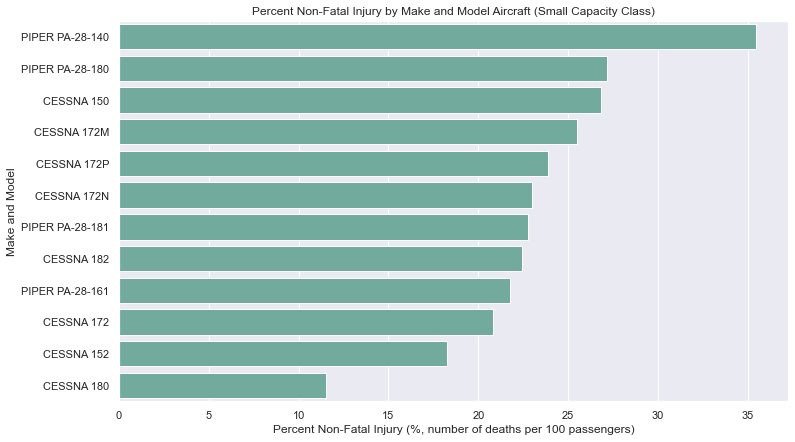

In [136]:
# look at just the small class for percent of Non-fatalities
plt.figure(figsize=(12, 7))
small_df = small_df.sort_values(['Percent.Non-Fatal.Injuries'], ascending=False).reset_index(drop=True)

# plot a bar chart
ax = sns.barplot(
    y='Make.Model', 
    x='Percent.Non-Fatal.Injuries', 
    data=small_df,
    estimator=sum, 
    errorbar=None, 
    color='#69b3a2')
x_min_fatals, x_max_fatals = ax.get_xlim()
ax.set(xlabel='Percent Non-Fatal Injury (%, number of deaths per 100 passengers)', ylabel='Make and Model')  # Set the labels
plt.title('Percent Non-Fatal Injury by Make and Model Aircraft (Small Capacity Class)')  # Optional: Add a title
plt.show()

# Small Class Result
Both the fatal and non-fatal injury rates above agree that the safest of the small class are:
1. Cessna 180
2. Cessna 152
3. Cessna 172

*As noted above, these are just rankings and we will not recommend the company purchase small class craft based on poor safety history



# Medium Class (3 to 150 Passenger) Analysis
We will first look at the Percent Fatal Injury data 

In [137]:
# safest medium class based on Percent of Fatalities
medium_df = agg_df[agg_df['Capacity.Class'] == 'Medium']
medium_df.sort_values(by='Percent.Fatal.Injuries', ascending=True).head(6)

,Make,Model,Make.Model,Median.Total.Passengers,Capacity.Class,Sum.Total.Non-Fatal.Injuries,Sum.Total.Fatal.Injuries,Sum.Total.Passengers,Percent.Non-Fatal.Injuries,Percent.Fatal.Injuries
19,BOEING,737-200,BOEING 737-200,82.0,Medium,38.0,0.0,1069.0,3.554724,0.0
21,BOEING,727-200,BOEING 727-200,71.0,Medium,36.0,0.0,1193.0,3.017603,0.0
22,BOEING,757-232,BOEING 757-232,148.0,Medium,45.0,0.0,2226.0,2.021563,0.0
25,BOEING,737,BOEING 737,121.0,Medium,35.0,0.0,3412.0,1.025791,0.0
28,BOEING,737-7H4,BOEING 737-7H4,136.0,Medium,11.0,0.0,1285.0,0.856031,0.0
30,BOEING,757-223,BOEING 757-223,149.0,Medium,7.0,0.0,1013.0,0.691017,0.0


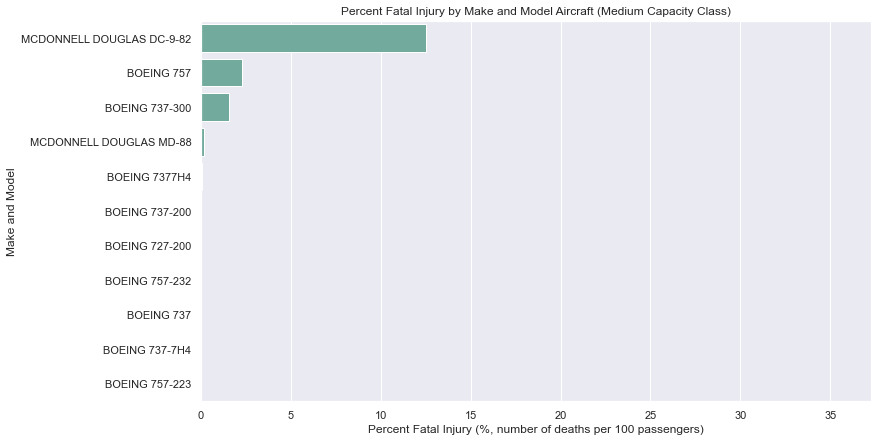

In [138]:
# look at just the medium class for percent of fatalities
plt.figure(figsize=(12, 7))
medium_df = medium_df.sort_values(['Percent.Fatal.Injuries'], ascending=False).reset_index(drop=True)

# plot a bar chart
ax = sns.barplot(
    y='Make.Model', 
    x='Percent.Fatal.Injuries', 
    data=medium_df,
    estimator=sum, 
    errorbar=None, 
    color='#69b3a2')
#normalize the x-axis between fatals graphs
ax.set_xlim([x_min_fatals, x_max_fatals])
ax.set(xlabel='Percent Fatal Injury (%, number of deaths per 100 passengers)', ylabel='Make and Model')  # Set the labels
plt.title('Percent Fatal Injury by Make and Model Aircraft (Medium Capacity Class)')  # Optional: Add a title
plt.show()

Because the top 6 safest based on fatal rates were all zero, we drill down into the non-fatal rates to make a determination. Because we are prioritizing fatal rates over non-fatal rates, we only use models that had zero fatal rates:

In [139]:
# safest medium class based on Percent of Non-Fatalities, where Fatalities = 0
medium_df_no_fatals = medium_df[medium_df['Percent.Fatal.Injuries'] == 0]
medium_df_no_fatals.sort_values(by='Percent.Non-Fatal.Injuries', ascending=True).head(10)

,Make,Model,Make.Model,Median.Total.Passengers,Capacity.Class,Sum.Total.Non-Fatal.Injuries,Sum.Total.Fatal.Injuries,Sum.Total.Passengers,Percent.Non-Fatal.Injuries,Percent.Fatal.Injuries
10,BOEING,757-223,BOEING 757-223,149.0,Medium,7.0,0.0,1013.0,0.691017,0.0
9,BOEING,737-7H4,BOEING 737-7H4,136.0,Medium,11.0,0.0,1285.0,0.856031,0.0
8,BOEING,737,BOEING 737,121.0,Medium,35.0,0.0,3412.0,1.025791,0.0
7,BOEING,757-232,BOEING 757-232,148.0,Medium,45.0,0.0,2226.0,2.021563,0.0
6,BOEING,727-200,BOEING 727-200,71.0,Medium,36.0,0.0,1193.0,3.017603,0.0
5,BOEING,737-200,BOEING 737-200,82.0,Medium,38.0,0.0,1069.0,3.554724,0.0


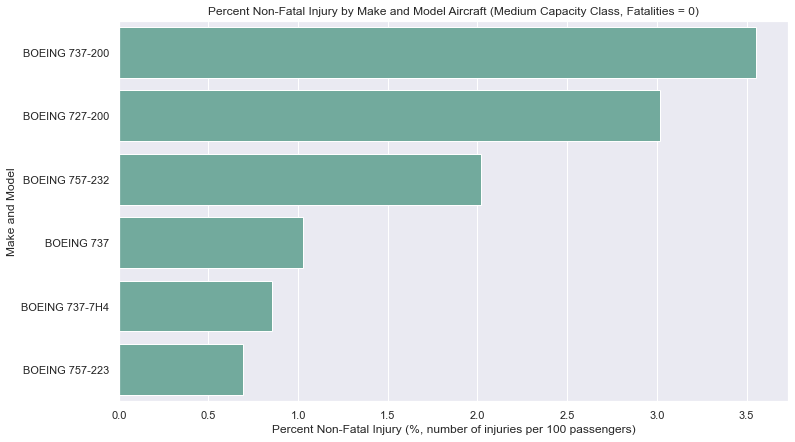

In [140]:
# look at just the medium class for percent of Non-fatalities, where fatalities = 0
plt.figure(figsize=(12, 7))
medium_df_no_fatals = medium_df_no_fatals.sort_values(['Percent.Non-Fatal.Injuries'], ascending=False).reset_index(drop=True)

# plot a bar chart
ax = sns.barplot(
    y='Make.Model', 
    x='Percent.Non-Fatal.Injuries', 
    data=medium_df_no_fatals,
    estimator=sum, 
    errorbar=None, 
    color='#69b3a2')
x_min_non_fatals, x_max_non_fatals = ax.get_xlim()
ax.set(xlabel='Percent Non-Fatal Injury (%, number of injuries per 100 passengers)', ylabel='Make and Model')  # Set the labels
plt.title('Percent Non-Fatal Injury by Make and Model Aircraft (Medium Capacity Class, Fatalities = 0)')  # Optional: Add a title
plt.show()

# Medium Class Result
Based on the analysis, we determine the safest in medium class to be:
1. Boeing 757-223
2. Boeing 737-7H4
3. Boeing 737

# Large Class (>150 Passenger) Analysis
We will first look at the Percent Fatal Injury data 

In [141]:
# top large class based on Percent of Fatalities
large_df = agg_df[agg_df['Capacity.Class'] == 'Large']
large_df.sort_values(by='Percent.Fatal.Injuries', ascending=True).head(8)

,Make,Model,Make.Model,Median.Total.Passengers,Capacity.Class,Sum.Total.Non-Fatal.Injuries,Sum.Total.Fatal.Injuries,Sum.Total.Passengers,Percent.Non-Fatal.Injuries,Percent.Fatal.Injuries
20,BOEING,747-136,BOEING 747-136,343.5,Large,45.0,0.0,1424.0,3.160112,0.0
26,BOEING,777-222,BOEING 777-222,296.0,Large,10.0,0.0,1061.0,0.942507,0.0
27,BOEING,777-223,BOEING 777-223,231.0,Large,9.0,0.0,1045.0,0.861244,0.0
29,BOEING,747-422,BOEING 747-422,307.0,Large,10.0,0.0,1253.0,0.798085,0.0
31,BOEING,777,BOEING 777,160.5,Large,7.0,0.0,1068.0,0.655431,0.0
32,BOEING,747-400,BOEING 747-400,250.0,Large,8.0,0.0,1367.0,0.585223,0.0
33,BOEING,757-222,BOEING 757-222,152.0,Large,7.0,0.0,1465.0,0.477816,0.0
35,AIRBUS,A321,AIRBUS A321,187.5,Large,2.0,0.0,1075.0,0.186047,0.0


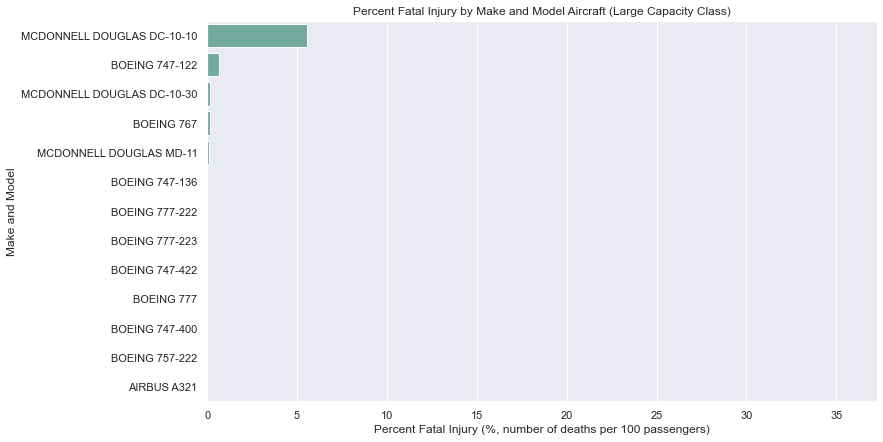

In [142]:
# look at just the large class for percent of fatalities
plt.figure(figsize=(12, 7))
large_df = large_df.sort_values(['Percent.Fatal.Injuries'], ascending=False).reset_index(drop=True)

# plot a bar chart
ax = sns.barplot(
    y='Make.Model', 
    x='Percent.Fatal.Injuries', 
    data=large_df,
    estimator=sum, 
    errorbar=None, 
    color='#69b3a2')
ax.set_xlim([x_min_fatals, x_max_fatals])
ax.set(xlabel='Percent Fatal Injury (%, number of deaths per 100 passengers)', ylabel='Make and Model')  # Set the labels
plt.title('Percent Fatal Injury by Make and Model Aircraft (Large Capacity Class)')  # Optional: Add a title
plt.show()

Again we see the top safest based on fatal rates were all zero, agaom drill down into the non-fatal rates to make a determination. Because we are prioritizing fatal rates over non-fatal rates, we only use models that had zero fatal rates:

In [143]:
# find the safest large class based on Percent of Non-Fatalities, where Fatalities = 0
large_df_no_fatals = large_df[large_df['Percent.Fatal.Injuries'] == 0]
large_df_no_fatals.sort_values(by='Percent.Non-Fatal.Injuries', ascending=True)

,Make,Model,Make.Model,Median.Total.Passengers,Capacity.Class,Sum.Total.Non-Fatal.Injuries,Sum.Total.Fatal.Injuries,Sum.Total.Passengers,Percent.Non-Fatal.Injuries,Percent.Fatal.Injuries
12,AIRBUS,A321,AIRBUS A321,187.5,Large,2.0,0.0,1075.0,0.186047,0.0
11,BOEING,757-222,BOEING 757-222,152.0,Large,7.0,0.0,1465.0,0.477816,0.0
10,BOEING,747-400,BOEING 747-400,250.0,Large,8.0,0.0,1367.0,0.585223,0.0
9,BOEING,777,BOEING 777,160.5,Large,7.0,0.0,1068.0,0.655431,0.0
8,BOEING,747-422,BOEING 747-422,307.0,Large,10.0,0.0,1253.0,0.798085,0.0
7,BOEING,777-223,BOEING 777-223,231.0,Large,9.0,0.0,1045.0,0.861244,0.0
6,BOEING,777-222,BOEING 777-222,296.0,Large,10.0,0.0,1061.0,0.942507,0.0
5,BOEING,747-136,BOEING 747-136,343.5,Large,45.0,0.0,1424.0,3.160112,0.0


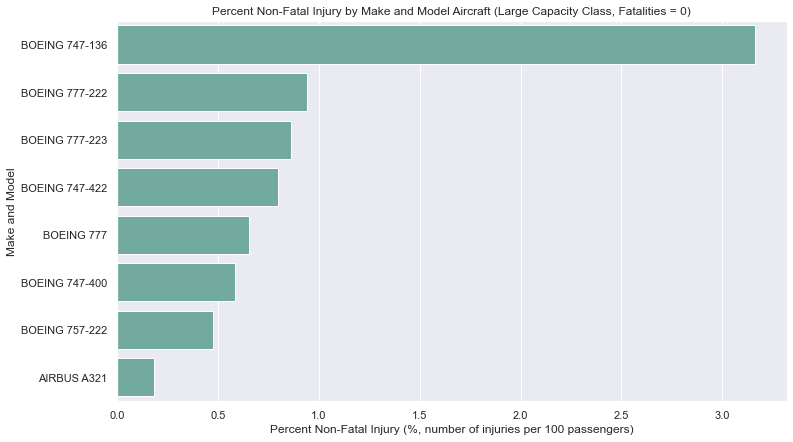

In [144]:
# look at just the medium class for percent of Non-fatalities, where fatalities = 0
plt.figure(figsize=(12, 7))
large_df_no_fatals = large_df_no_fatals.sort_values(['Percent.Non-Fatal.Injuries'], ascending=False).reset_index(drop=True)

# plot a bar chart
ax = sns.barplot(
    y='Make.Model', 
    x='Percent.Non-Fatal.Injuries', 
    data=large_df_no_fatals,
    estimator=sum, 
    errorbar=None, 
    color='#69b3a2')
x_min_non_fatals, x_max_non_fatals = ax.get_xlim()
ax.set(xlabel='Percent Non-Fatal Injury (%, number of injuries per 100 passengers)', ylabel='Make and Model')  # Set the labels
plt.title('Percent Non-Fatal Injury by Make and Model Aircraft (Large Capacity Class, Fatalities = 0)')  # Optional: Add a title
plt.show()

# Large Class Result
Based on the analysis, we determine the safest large class craft to be:
1. Airbus A321
2. Boeing 757-222
3. Boeing 747-400

# Conclusions

- For the Medium Class aircraft models, we recommend the following:
    1. Boeing 757-223
    2. Boeing 737-7H4
    3. Boeing 737
 
 
- For the Large Class aircraft models, we recommend the following:
    1. Airbus A321
    2. Boeing 757-222
    3. Boeing 747-400
 
 
- We <u>do not</u> recommend the use of Small Class planes because their fatality rate is much higher.
    - If necessary, the safest of the small class are:
        1. Cessna 180
        2. Cessna 152
        3. Cessna 172 

# Next Steps
- Analyze geographic location effects for recommended models to optimize safety
- Acquire non-accident flight record data to analyze the volume of safe flights by model and potential markets
- Return on Investment (ROI) analysis based on MSRP data, purchase availability and loan rates for safe model recommendations
